In [1]:
# SKIP THIS IF YOU WANT TO USE THE NON WEB INTERFACE (can only be done when notebook run locally)
%matplotlib inline

In [2]:
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic(u'load_ext autoreload')
        get_ipython().magic(u'autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
#import matplotlib as mpl
#mpl.use('TkAgg')

from matplotlib import pyplot as plt
import pylab as pl
#pl.ion()

import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf

numba not found


In [3]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cmap
import numpy as np

bpl.output_notebook()

Loading BokehJS ...

In [4]:
# frame rate in Hz
final_frate=200 

#%%
#backend='SLURM'
backend='local'
if backend == 'SLURM':
    n_processes = np.int(os.environ.get('SLURM_NPROCS'))
else:
    n_processes = np.maximum(np.int(psutil.cpu_count()),1) # roughly number of cores on your machine minus 1
print 'using ' + str(n_processes) + ' processes'
#%% start cluster for efficient computation
single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print 'C was not existing, creating one'
    print "Stopping  cluster to avoid unnencessary use of memory...."
    sys.stdout.flush()  
    if backend == 'SLURM':
        try:
            cm.stop_server(is_slurm=True)
        except:
            print 'Nothing to stop'
        slurm_script='/mnt/xfs1/home/agiovann/SOFTWARE/Constrained_NMF/SLURM/slurmStart.sh'
        cm.start_server(slurm_script=slurm_script)
        pdir, profile = os.environ['IPPPDIR'], os.environ['IPPPROFILE']
        c = Client(ipython_dir=pdir, profile=profile)        
    else:
        cm.stop_server()
        cm.start_server()        
        c=Client()

    print 'Using '+ str(len(c)) + ' processes'
    dview=c[:len(c)]

using 24 processes
C was not existing, creating one
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
Starting cluster...Waiting for connection file: /rugpfs/fs0/home/sweisenbur/.ipython/profile_default/security/ipcontroller-client.json
......Using 24 processes


In [5]:
#%% FOR LOADING ALL TIFF FILES IN A FILE AND SAVING THEM ON A SINGLE MEMORY MAPPABLE FILE
fnames=[]
base_folder='./example_movies/' # folder containing the demo files
for file in glob.glob(os.path.join(base_folder,'*.tif')):
    if file.endswith(".tif"):
        fnames.append(os.path.abspath(file))
fnames.sort()
print fnames
#%%
#idx_x=slice(12,500,None)
#idx_y=slice(12,500,None)
#idx_xy=(idx_x,idx_y)
downsample_factor=.1 # use .2 or .1 if file is large and you want a quick answer
final_frate=final_frate*downsample_factor
idx_xy=None
base_name='Yr'
name_new=cm.save_memmap_each(fnames, dview=dview,base_name=base_name, resize_fact=(1, 1, downsample_factor), remove_init=0,idx_xy=idx_xy )
#name_new.sort()
print name_new
#%%
name_new=cm.save_memmap_each(fnames, dview=dview,base_name='Yr', resize_fact=(1, 1, 1), remove_init=0, idx_xy=None)
name_new.sort()
#%%
fname_new=cm.save_memmap_join(name_new,base_name='Yr', n_chunks=12, dview=dview)

['/rugpfs/fs0/home/sweisenbur/CaImAn/example_movies/m23_3p_1100um_depth_100pc_00001-deci.tif']
['/rugpfs/fs0/home/sweisenbur/CaImAn/example_movies/Yr0000_d1_60_d2_55_d3_1_order_C_frames_6000_.mmap']
('/rugpfs/fs0/home/sweisenbur/CaImAn/example_movies/Yr0000_d1_60_d2_55_d3_1_order_C_frames_60000_.mmap', 60000)
/rugpfs/fs0/home/sweisenbur/CaImAn/example_movies/Yr_d1_60_d2_55_d3_1_order_C_frames_60000_.mmap
Deleting big mov


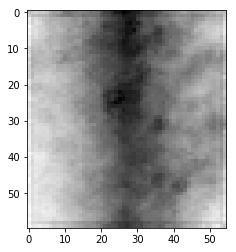

In [6]:
#%%
Yr,dims,T=cm.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
#%% visualize correlation image
Cn = cm.local_correlations(Y)
pl.imshow(Cn,cmap='gray') 
pl.show()

In [7]:
#%% parameters of experiment
K=50 # number of neurons expected per patch
gSig=[4,4] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=2 #order of the autoregressive system
options = cnmf.utilities.CNMFSetParms(Y,n_processes,p=p,gSig=gSig,K=K,ssub=2,tsub=2, normalize_init=True)
#%% PREPROCESS DATA AND INITIALIZE COMPONENTS
t1 = time()
Yr,sn,g,psx = cnmf.pre_processing.preprocess_data(Yr,dview=dview,**options['preprocess_params'])
print time() - t1
#%%
t1 = time()
Atmp, Ctmp, b_in, f_in, center=cnmf.initialization.initialize_components(Y, **options['init_params'])                                                    
print time() - t1

using 24 processes
using 1000 pixels per process
using 1000 block_size
checking if missing data
Running on 24 engines.
3.08584308624
Noise Normalization
Spatial Downsampling ...
Roi Extraction...
Refining Components...
8.57352805138


In [8]:
refine_components=False
if refine_components:
    Ain,Cin = manually_refine_components(Y,options['init_params']['gSig'],coo_matrix(Atmp),Ctmp,Cn,thr=0.9)
else:
    Ain,Cin = Atmp, Ctmp

In [9]:
pl.close('all')

In [10]:
#p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
#bpl.show(p1)

In [11]:
#%% UPDATE SPATIAL COMPONENTS
pl.close()
t1 = time()
A,b,Cin,f_in = cnmf.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, dview=dview,**options['spatial_params'])
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

found spatial support for each component
(3300, 50)
Starting Update Spatial Components
Updated Spatial Components
threshold
Computing residuals
parallel dot product block size: 1000
Start product
Filling
Computing A_bas
--- 30.1448659897 seconds ---
Remove temporary file created
30.1835329533
DONE!


In [12]:
#pl.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
#crd = plot_contours(A,Cn,thr=0.9)
#pl.show()

In [13]:
#pl.close('all')

In [14]:
#p1=nb_plot_contour(Cn,A.todense(),dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
#bpl.show(p1)

In [15]:
pl.close()
t1 = time()
options['temporal_params']['p'] = 0 # set this to zero for fast updating without deconvolution
C,A,b,f,S,bl,c1,neurons_sn,g,YrA = cnmf.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL = time() - t1
print t_elTEMPORAL  
clear_output(wait=True)

Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3299
Done
2 out of total 50 temporal components updated
6 out of total 50 temporal components updated
11 out of total 50 temporal components updated
19 out of total 50 temporal components updated
28 out of total 50 temporal components updated
36 out of total 50 temporal components updated
41 out of total 50 temporal components updated
50 out of total 50 temporal components updated
1 out of total 50 temporal components updated
3 out of total 50 temporal components updated
8 out of total 50 temporal components updated
16 out of total 50 temporal components updated
23 out of total 50 temporal components updated
31 out of total 50 temporal components updated
40 out of total 50 temporal components updated
50 out of total 50 temporal components updated
stopping: overall temporal component not changing significantly
5.07431292534


In [16]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cnmf.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'],dview=dview, bl=bl, c1=c1, sn=neurons_sn, g=g, thr=merge_thresh, mx=50, fast_merge = True)
t_elMERGE = time() - t1
print t_elMERGE

********** No neurons merged! ***************
done merging
0.104314804077


/ru-auth/local/home/sweisenbur/anaconda2/envs/nmf/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [17]:
#refine spatial and temporal components
pl.close()
t1 = time()
A2,b2,C2,f = cnmf.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn,dview=dview, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to original value to perform full deconvolution
C2,A2,b2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cnmf.temporal.update_temporal_components(Yr,A2,b2,C2,f,dview=dview, bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
clear_output(wait=True)
print time() - t1 # 100 seconds
print('DONE!')

44.5488731861
DONE!


In [18]:
tB = np.minimum(-2,np.floor(-5./30*final_frate))
tA = np.maximum(5,np.ceil(25./30*final_frate))
Npeaks=10
traces=C2+YrA
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = \
    evaluate_components(Y, traces, A, C, b, f, final_frate, remove_baseline=True,
                                      N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)
    
idx_components_r=np.where(r_values>=.6)[0]
idx_components_raw=np.where(fitness_raw<-60)[0]        
idx_components_delta=np.where(fitness_delta<-20)[0]   


min_radius=gSig[0]-2
masks_ws,idx_blobs,idx_non_blobs=extract_binary_masks_blob(
A2.tocsc(), min_radius, dims, num_std_threshold=1, 
minCircularity= 0.6, minInertiaRatio = 0.2,minConvexity =.8)




idx_components=np.union1d(idx_components_r,idx_components_raw)
idx_components=np.union1d(idx_components,idx_components_delta)  
idx_blobs=np.intersect1d(idx_components,idx_blobs)   
idx_components_bad=np.setdiff1d(range(len(traces)),idx_components)
clear_output(wait=True)
print(' ***** ')
print len(traces)
print(len(idx_components))
print(len(idx_blobs))

 ***** 
50
5
4


caiman/utils/visualization.py:847: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


(60, 55)


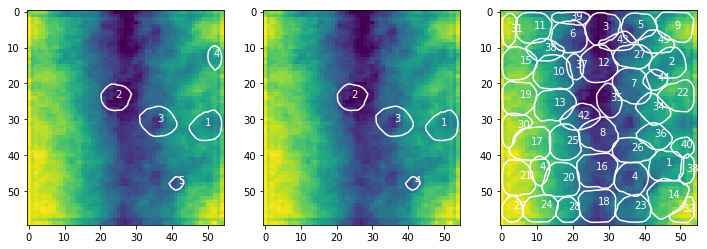

In [19]:
fg=pl.figure(figsize=(12,20))
pl.subplot(1,3,1)
crd = plot_contours(A2.tocsc()[:,idx_components],Cn,thr=0.9)
pl.subplot(1,3,2)
crd = plot_contours(A2.tocsc()[:,idx_blobs],Cn,thr=0.9)
pl.subplot(1,3,3)
crd = plot_contours(A2.tocsc()[:,idx_components_bad],Cn,thr=0.9)
print dims

In [20]:
#p2=nb_plot_contour(Cn,A2.tocsc()[:,idx_components].todense(),dims[0],dims[1],thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
#bpl.show(p2)

In [21]:
#traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components].todense(),C[idx_components],b2,f2,dims[0],dims[1],thr = 0.9,image_neurons=None)

In [22]:
#%% SAVE DATA
import h5py
with h5py.File('../data/test-results-2d.h5', 'w') as hf:
    hf.create_dataset("C",  data=C)
    hf.create_dataset("f2",  data=f2)
    hf.create_dataset("b2",  data=b2)
    hf.create_dataset("idx_components",  data=idx_components)

In [23]:
#%% STOP CLUSTER
#cm.stop_server()